In [1]:
import unicodedata

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from commons import DATASET_CLEAN_LOCATION, DATASET_CLEAN_UNDERSAMPLING_LOCATION, DATASET_LOCATION

# Data Cleaning

We import the dataset used in the data exploration phase and create two new columns containing the labels "Italian" and "Not Italian" and the associated label 1 and 0


In [2]:
df = pd.read_csv(DATASET_LOCATION)

In [3]:
df["Label Binary Language"] = df["Language"].apply(lambda x: "Italian" if x == "Italian" else "Not Italian")
df["Binary Language"] = df["Language"].apply(lambda x: 1 if x == "Italian" else 0)

The function `clean_text_keep_accents` is used within the main cleaning pipeline to filter out unwanted Unicode characters that the primary cleaning function might miss.

Specifically, it removes all special characters except letters (including accented characters), numbers, and whitespace. It preserves accented letters by checking Unicode categories starting with "L" (letters) and "N" (numbers), while excluding characters categorized as modifier letters and punctuation. This ensures that important accented characters remain intact for languages like Italian, while unwanted symbols and special characters are removed.


In [4]:
def clean_text_keep_accents(text: str) -> str:
    """
    Clean a string by removing special characters while preserving accents.

    This function removes all characters from the input string except letters,
    numbers, and whitespace. It retains accented characters and strips out
    special symbols, including modifier letters and punctuation.

    Args:
        text (str): The input text string to be cleaned.

    Returns:
        str: The cleaned text with accents preserved and special characters removed.

    """
    return "".join(
        c for c in text
        if (
            unicodedata.category(c).startswith(("L", "N")) or c.isspace()
        )
        and not unicodedata.name(c, "").startswith("MODIFIER")
    )

This function `clean_text` performs a series of preprocessing steps to clean and normalize the input text:

- Converts the entire text to lowercase to ensure uniformity.
- Replaces apostrophes with spaces to prevent contractions (e.g., "l'uomo" becomes two separate tokens: "l" and "uomo").
- Removes all digits from the text.
- Keeps only alphanumeric characters and whitespace, removing other punctuation.
- Cleans remaining Unicode characters by calling `clean_text_keep_accents`, which preserves accented characters while removing unwanted symbols.
- Normalizes whitespace by collapsing multiple spaces into a single space, ensuring consistent token separation.


In [5]:
def clean_text(text: str) -> str:
    """
    Clean and normalizes a text string by lowercasing, removing digits, and stripping punctuation.

    This function performs several text preprocessing steps:
    - Converts all characters to lowercase.
    - Replaces apostrophes with spaces.
    - Removes all digits.
    - Keeps only alphanumeric characters and whitespace.
    - Cleans remaining Unicode characters while preserving accents (via `clean_text_keep_accents`).
    - Normalizes whitespace to ensure consistent spacing.

    Args:
        text (str): The input text string to be cleaned.

    Returns:
        str: The cleaned and normalized text.

    """
    text = text.lower()
    text = text.replace("'", " ")
    text = "".join(c for c in text if not c.isdigit())
    text = "".join(c for c in text if c.isalnum() or c.isspace())
    text = clean_text_keep_accents(text)
    return  " ".join(text.split())

We apply the cleaning function to the dataset and save the cleaned version for the training phase.


In [6]:
df["Text_clean"] = df["Text"].apply(clean_text)
df = df[df["Text_clean"].str.strip().astype(bool)]

In [7]:
df_clean = df[["Text_clean", "Binary Language"]]
df_clean = df_clean.rename(columns={"Text_clean": "Text"})

In [8]:
df_clean.to_csv(DATASET_CLEAN_LOCATION, index=False)

We generate a balanced dataset via undersampling, maintaining a fixed ratio (`RATIO_ITALIAN_NOT_ITALIAN`) between Italian and non-Italian sentences.

Procedure:
- Calculate the word count (`Word_count`) for each sentence.
- Split the dataset into Italian (`Binary Language == 1`) and non-Italian (`Binary Language == 0`) subsets.
- Compute the proportion of each non-Italian language.
- For each non-Italian language:
  - Determine the number of sentences to sample proportionally to the number of Italian sentences and the fixed ratio.
  - Divide sentences into 4 quartiles based on `Word_count`.
  - Uniformly sample from each quartile.
- Combine Italian sentences with the sampled non-Italian sentences to create the final balanced dataset.


In [9]:
RATIO_ITALIAN_NOT_ITALIAN = 1

df["Word_count"] = df["Text_clean"].apply(lambda x: len(str(x).split()))
df_it = df[df["Binary Language"] == 1].copy()
df_non_it = df[df["Binary Language"] == 0].copy()
n_italian = len(df_it)
total_non_it = len(df_non_it)
not_it_lang_proportion = df_non_it["Language"].value_counts(normalize=True)
non_it_samples = []
for lang, perc in not_it_lang_proportion.items():
    df_lang = df_non_it[df_non_it["Language"] == lang].copy()
    n_total_for_lang = round(perc * n_italian) * RATIO_ITALIAN_NOT_ITALIAN
    df_lang["quartile"] = pd.qcut(df_lang["Word_count"], q=4, labels=False)
    n_per_quartile = n_total_for_lang // 4
    sampled_quartiles = []
    for q in range(4):
        group = df_lang[df_lang["quartile"] == q]
        sample_q = group.sample(n=min(n_per_quartile, len(group)), random_state=1999)
        sampled_quartiles.append(sample_q)
    lang_sampled = pd.concat(sampled_quartiles)
    non_it_samples.append(lang_sampled)
df_clean_undersampling = pd.concat([df_it, *non_it_samples]).reset_index(drop=True)

We reprint the language distribution to verify that the undersampling was performed correctly.


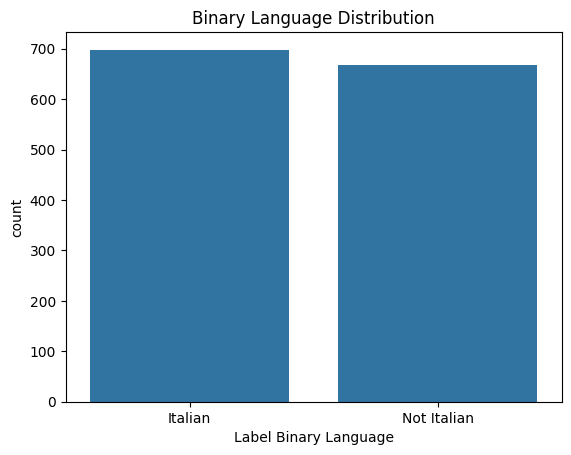

Binary Language
1    0.510981
0    0.489019
Name: proportion, dtype: float64


In [10]:
sns.countplot(x="Label Binary Language", data=df_clean_undersampling)
plt.title("Binary Language Distribution")
plt.show()

print(df_clean_undersampling["Binary Language"].value_counts(normalize=True))

We also save this version of the dataset for the training phase.


In [11]:
df_clean_undersampling = df_clean_undersampling[["Text_clean", "Binary Language"]]
df_clean_undersampling = df_clean_undersampling.rename(columns={"Text_clean": "Text"})

In [12]:
df_clean_undersampling.to_csv(DATASET_CLEAN_UNDERSAMPLING_LOCATION, index=False)